# Aggregation: Quantile

This notebook explains the b-ary tree technique for releasing quantiles.
Examples in this notebook will a dataset sampled from $Exponential(\lambda=20)$.

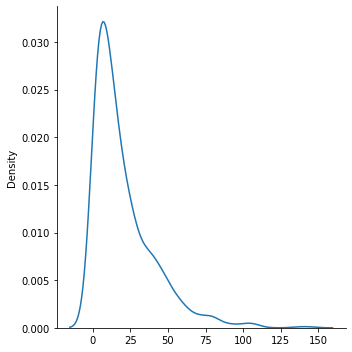

In [121]:
# privacy settings for all examples:
max_contributions = 1
epsilon = 1.

import numpy as np
data = np.random.exponential(20., size=1000)
bounds = 0., 100. # a best guess!

import seaborn as sns
sns.displot(data, kind="kde");

In [122]:
# true quantiles
true_quantiles = np.quantile(data, [0.25, 0.5, 0.75])
true_quantiles.tolist()


[5.754720694200086, 13.448712679130452, 27.952153017876828]

----

Any constructors that have not completed the proof-writing and vetting process may still be accessed if you opt-in to "contrib".
Please contact us if you are interested in proof-writing. Thank you!

In [123]:
from opendp.mod import enable_features
enable_features("contrib")

## Quantile via Histogram

One approach for releasing quantiles is to estimate the cumulative distribution via a histogram query.

The basic procedure for estimating an $\alpha$-quantile is as follows:

1. bin the data, and count the number of elements in each bin privately
2. divide the counts by the total to get the probability density of landing in each bin
3. sum the densities while scanning from the left until the sum is at least $\alpha$
4. interpolate the bin edges of the terminal bin

In [124]:
from opendp.transformations import *
from opendp.measurements import make_base_discrete_laplace
from opendp.mod import binary_search_chain

quart_alphas = [0.25, 0.5, 0.75]

def make_hist_quantiles(alphas, d_in, d_out, num_bins=500):

    edges = np.linspace(*bounds, num=num_bins + 1)
    bin_names = [str(i) for i in range(num_bins)]

    def make_from_scale(scale):
        return (
            make_find_bin(edges=edges) >> # bin the data
            make_index(bin_names, "0") >> # can be omitted. Just change TIA to "usize" on next line:
            make_count_by_categories(TIA="String", categories=bin_names, null_category=False) >>
            make_base_discrete_laplace(scale, D="VectorDomain<AllDomain<int>>") >>
            make_cast_default(TIA=int, TOA=float) >>
            make_quantiles_from_counts(edges, alphas=alphas)
        )

    return binary_search_chain(make_from_scale, d_in, d_out)

hist_quartiles_meas = make_hist_quantiles(quart_alphas, max_contributions, epsilon)
hist_quartiles_meas(data)


[5.850000000000001, 13.200000000000001, 28.433333333333337]

A drawback of using this algorithm is that it can be difficult to choose the number of bins.

If the number of bins is chosen to be very small, then the postprocessor will need to sum fewer instances of noise before reaching the bin of interest, resulting in a better bin selection.
However, the bin will be wider, so there will be greater error when interpolating the final answer.

If the number of bins is chosen to be very large, then the same holds in the other direction.

Estimating quantiles via the next algorithm can help make choosing the number of bins less sensitive.


## Quantile via B-ary Tree

A slightly more complicated algorithm that tends to provide better utility is to privatize a B-ary tree instead of a histogram.
In this algorithm, the raw counts form the leaf nodes, and a complete tree is constructed by recursively summing groups of size `b`.
This results in a structure where each parent node is the sum of its `b` children.
Noise is added to each node in the tree, and then a postprocessor makes all nodes of the tree consistent with each other, and returns the leaf nodes.

In the histogram approach, the postprocessor would be influenced by a number of noise sources approximately $O(n)$ in the number of scanned bins.
After this modification, the postprocessor is influenced by a number of noise sources approximately $O(log_b(n))$ in the number of scanned bins, and with noise sources of similarly greater magnitude.

This modification introduces a new hyperparameter, the branching factor.
`choose_branching_factor` provides a heuristic for the ideal branching factor, based on information (or a best guess) of the dataset size.

In [125]:
b = choose_branching_factor(size_guess=1_500)
b

25


We now make the following adjustments to the histogram algorithm:

* insert a Lipschitz transformation to construct a b-ary tree before the noise mechanism
* replace the cast postprocessor with a consistency postprocessor


In [126]:
def make_tree_quantiles(alphas, b, d_in, d_out, num_bins=500):

    edges = np.linspace(*bounds, num=num_bins + 1)
    bin_names = [str(i) for i in range(num_bins)]

    def make_from_scale(scale):
        return (
            make_find_bin(edges=edges) >> # bin the data
            make_index(bin_names, "0") >> # can be omitted. Just change TIA to "usize" on next line:
            make_count_by_categories(TIA="String", categories=bin_names, null_category=False) >>
            make_b_ary_tree(leaf_count=len(bin_names), branching_factor=b, M="L1Distance<int>") >>
            make_base_discrete_laplace(scale, D="VectorDomain<AllDomain<int>>") >> 
            make_consistent_b_ary_tree(branching_factor=b) >> 
            make_quantiles_from_counts(edges, alphas=alphas)
        )

    return binary_search_chain(make_from_scale, d_in, d_out)

tree_quartiles_meas = make_tree_quantiles(quart_alphas, b, max_contributions, epsilon)
tree_quartiles_meas(data)

[5.486171566284501, 13.547920776969864, 27.138918129988557]

As mentioned earlier, using the tree-based approach can help make the algorithm less sensitive to the number of bins:

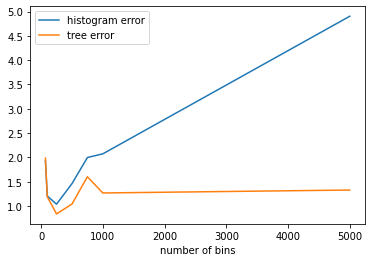

In [142]:
num_trials = 100
def average_error(num_bins):
    hist_quantiles_meas = make_hist_quantiles(quart_alphas, max_contributions, epsilon, num_bins)
    tree_quantiles_meas = make_tree_quantiles(quart_alphas, b, max_contributions, epsilon, num_bins)

    def sample_error(meas):
        return np.linalg.norm(true_quantiles - meas(data))
    
    hist_err = np.mean([sample_error(hist_quantiles_meas) for _ in range(num_trials)])
    tree_err = np.mean([sample_error(tree_quantiles_meas) for _ in range(num_trials)])

    return num_bins, hist_err, tree_err

import pandas as pd
pd.DataFrame(
    [average_error(num_bins) for num_bins in [70, 100, 250, 500, 750, 1_000, 5_000]],
    columns=["number of bins", "histogram error", "tree error"]
).plot(0);

## Privately Estimating the Distribution

Minor note: instead of postprocessing the noisy counts into quantiles, they can be left as counts, which can be used to visualize the distribution.



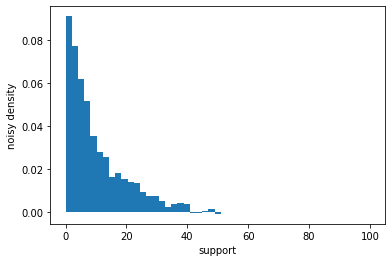

In [165]:
def make_distribution_counts(edges, scale):
    bin_names = [str(i) for i in range(len(edges - 1))]
    from opendp.combinators import make_default_user_postprocessor
    enable_features("honest-but-curious")

    return (
        make_find_bin(edges=edges) >> # bin the data
        make_index(bin_names, "0") >> # can be omitted. Just change TIA to "usize" on next line:
        make_count_by_categories(TIA="String", categories=bin_names, null_category=False) >>
        make_base_discrete_laplace(scale, D="VectorDomain<AllDomain<int>>")
    )

edges = np.linspace(*bounds, num=50)
counts = make_distribution_counts(edges, scale=1.)(data)

import matplotlib.pyplot as plt

plt.hist(range(len(edges)), edges, weights=counts, density=True)
plt.xlabel("support")
plt.ylabel("noisy density");